<a href="https://colab.research.google.com/github/Varchala/Secure_Private_AI/blob/main/privacy_attacks_varchala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refered the following Link to implement basic privacy attacks on sample model

https://franziska-boenisch.de/posts/2021/01/membership-inference/

In [ ]:

!pip install -U git+https://github.com/tensorflow/privacy


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import special


from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [3]:

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

/usr/local/lib/python3.7/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10()

169017344/169001437 [==============================] - 3s 0us/step


In [4]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  train, test = tf.keras.datasets.cifar100.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(100)(x)
  model = Model(i, x)
  return model

In [7]:
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [8]:

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:

history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=5)

Epoch 1/5
391/391 [==============================] - 6s 15ms/step - loss: 4.0581 - accuracy: 0.0809 - val_loss: 3.6295 - val_accuracy: 0.1513
Epoch 2/5
391/391 [==============================] - 6s 14ms/step - loss: 3.4624 - accuracy: 0.1770 - val_loss: 3.2791 - val_accuracy: 0.2126
Epoch 3/5
391/391 [==============================] - 6s 15ms/step - loss: 3.1833 - accuracy: 0.2267 - val_loss: 3.1120 - val_accuracy: 0.2492
Epoch 4/5
391/391 [==============================] - 6s 14ms/step - loss: 3.0102 - accuracy: 0.2578 - val_loss: 3.0650 - val_accuracy: 0.2502
Epoch 5/5
391/391 [==============================] - 5s 14ms/step - loss: 2.8682 - accuracy: 0.2871 - val_loss: 2.9290 - val_accuracy: 0.2785


(0.0, 1.0)

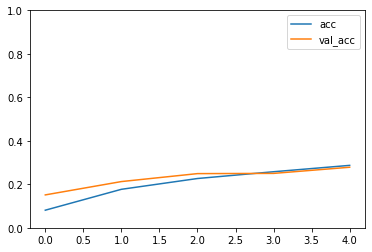

In [11]:

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

In [12]:

print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [13]:

attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [14]:

slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [15]:

attack_types = [
    AttackType.THRESHOLD_ATTACK
]

In [16]:
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [17]:
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.64 on slice CLASS=98
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.25 on slice CLASS=98

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.52
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.04

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.49
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.06

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.49
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.05

Best-performing attacks over slice: "CLASS=2"
  THRESHOLD_ATTAC

Figure(432x288)


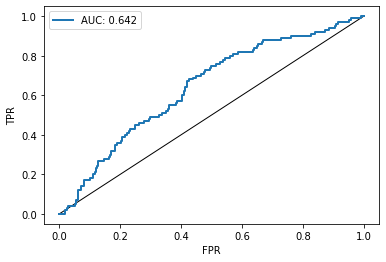

In [18]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))